# Replicar fitting de muertes por provincias, tres-6 meses

In [2]:
using CSV
using DataFrames
using Plots
using MMCAcovid19
using Random
using Distributions
using LightGraphs
using NamedArrays
using LinearAlgebra

In [3]:
data_path = "../data_provinces"

provincias = CSV.read(joinpath(data_path, "provincias.csv"), DataFrame)
nᵢᵍ = copy(transpose(convert(Array{Float64,2}, provincias[:,["Y", "M", "O"]])))
nᵢ = sum(nᵢᵍ, dims=1)
nothing

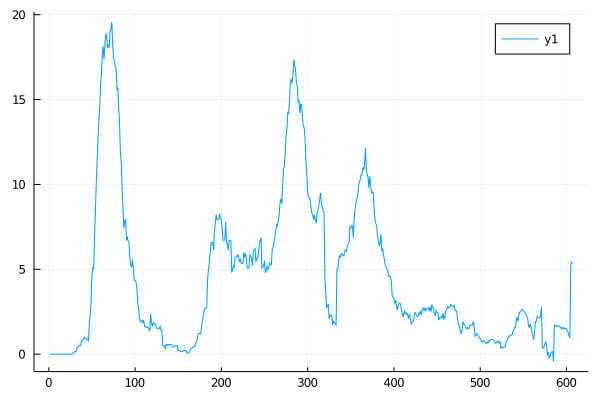

In [27]:
real_data = CSV.read(joinpath(data_path, "daily_deaths.csv"), DataFrame)
# days = max(real_data[:,"t"]...) + 1
# patches = max(real_data[:, "idx"]...)
# real_incidence = zeros(patches, days)
# nothing
real_deaths = unstack(real_data[:,[:ine_code, :date, :daily_deaths]], :ine_code, :date, :daily_deaths)
real_deaths = Array(real_deaths)[:, 40:end-1]
plot(real_deaths[50, :])

In [5]:
# load containment measures
kappa0 = CSV.read(joinpath(data_path, "kappa0_from_mitma.csv"), DataFrame)

# Timesteps when the containment measures will be applied
tᶜs = kappa0.time[:]

# Array of level of confinement
κ₀s = kappa0.reduction[:]
nothing

In [6]:
network = CSV.read(joinpath(data_path, "R_mobility_matrix.csv"), DataFrame)
edgelist = convert(Array{Int64, 2}, network[:, ["source_idx", "target_idx"]])
Rᵢⱼ = copy(network[:, "trips_norm"])

# Number of strata
G = size(nᵢᵍ)[1]

# Number of patches
M = size(nᵢᵍ)[2]

# Strata contacts
C = [0.5980 0.3849 0.0171
     0.2440 0.7210 0.0350
     0.1919 0.5705 0.2376]

# Patch surfaces (in km²)
sᵢ = provincias[:, "area"]

# Average number of contacts per strata
kᵍ = [11.8, 13.3, 6.6]

# Average number of contacts at home per strata
kᵍ_h = [3.15, 3.17, 3.28]

# Average number of contacts at work per strata
kᵍ_w = [1.72, 5.18, 0.0]

# Degree of mobility per strata
pᵍ = [0.0, 1.0, 0.05]

# Density factor
ξ = 0.01

# Average household size
σ = 2.5

# Infectivity of infected
βᴵ = 0.075

# Infectivity of asymptomatic
βᴬ = 0.5 * βᴵ

# Exposed rate
ηᵍ = [1/2.444, 1/2.444, 1/2.444]

# Asymptomatic infectious rate
αᵍ = [1/5.671, 1/2.756, 1/2.756]

# Infectious rate
μᵍ = [1/1.0, 1/3.915, 1/3.915]

# Direct death probability
θᵍ = [0.0, 0.008, 0.047]

# ICU probability
γᵍ = [0.0003, 0.003, 0.026]

# Pre-deceased rate
ζᵍ = [1/7.084, 1/7.084, 1/7.084]

# Pre-hospitalized in ICU rate
λᵍ = [1/4.084, 1/4.084, 1/4.084]

# Fatality probability in ICU
ωᵍ = [0.3, 0.3, 0.3]

# Death rate in iCU
ψᵍ = [1/7.0, 1/7.0, 1/7.0]

# ICU discharge rate
χᵍ = [1/20.0, 1/20.0, 1/20.0]

# Number of timesteps
T = 10

# # Timestep of application of containment
# tᶜ = 30

# # Mobility reduction
# κ₀ = 0.65

# # Permeability of confined households
# ϕ = 0.174

# # Social distancing
# δ = 0.207

# # List of timesteps of application of containments
# tᶜs = [30, 60, 90, 120]

# # List of mobility reductions
# κ₀s = [0.65, 0.75, 0.65, 0.55]

# # List of permeabilities of confined households
# ϕs = [0.174, 0.174, 0.174, 0.174]

# # List of social distancings
# δs = [0.207, 0.207, 0.207, 0.207]

# Array of premeabilities of confined households
ϕs = ones(Float64, length(tᶜs))

# Array of social distancing measures
δs = zeros(Float64, length(tᶜs))
nothing

In [63]:
using Evolutionary

function run_model(params; return_trajectories=false)
    beta = params[1]
    scale_beta = params[2]
    seeds_multiplier = params[3]
    seeds = params[4:end]
    seeds = seeds .* seeds_multiplier 
    
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)
    E₀ = zeros(G, M)
    A₀ = zeros(G, M)
    I₀ = zeros(G, M)

    epi_params.βᴵ .= beta
    epi_params.βᴬ .= scale_beta * beta
    E₀[2,:] = seeds

    reset_params!(epi_params, population)
    set_initial_infected!(epi_params, population, E₀, A₀, I₀)
    ϕs = ones(Float64, length(tᶜs)) # Array of premeabilities of confined households
    δs = zeros(Float64, length(tᶜs)) # Array of social distancing measures
    run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs; verbose = false)
    # run_epidemic_spreading_mmca!(epi_params, population; verbose = false)
        
    # compute total deaths and new deaths
    total_deaths = sum(epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .* population.nᵢᵍ, dims = (1))[1,:,:]
    deaths = diff(total_deaths, dims=2)

    # calculate vector of errors (one error for each province): first compare trajectories and then sum the errors
    # err = sum(abs2.(deaths - real_deaths[:, 1:T-1]), dims=2)[:,1]

    # calculate one single error at spain level: first sum trajectories, then compute the errors
    err = sum(abs2.(sum(deaths, dims=1)[1,:] - sum(real_deaths[:, 1:T-1], dims=1)[1,:]))
    
    if return_trajectories
        return deaths
    else
        return mean(err)
    end
end


run_model (generic function with 1 method)

In [8]:

function plot_multiple_provinces()
    provinces_names = provincias[:, "provincia"]
    num_provinces = 52 
    limit = T-1
    fig = plot(layout=num_provinces+1, legend=false, size=(1000, 1500))
    for i in 1:num_provinces
        plot!(fig, real_deaths[i,1:limit], subplot=i, title=provinces_names[i])
        plot!(fig, deaths[i,1:limit], subplot=i, color="red")
    end

    plot!(fig, sum(real_deaths[:, 1:limit], dims=1)[1,:], subplot=num_provinces+1, title="spain")
    plot!(fig, sum(deaths[:,1:limit], dims=1)[1,:], subplot=num_provinces+1, color="red")

    return fig
end

plot_multiple_provinces (generic function with 1 method)

## Manually

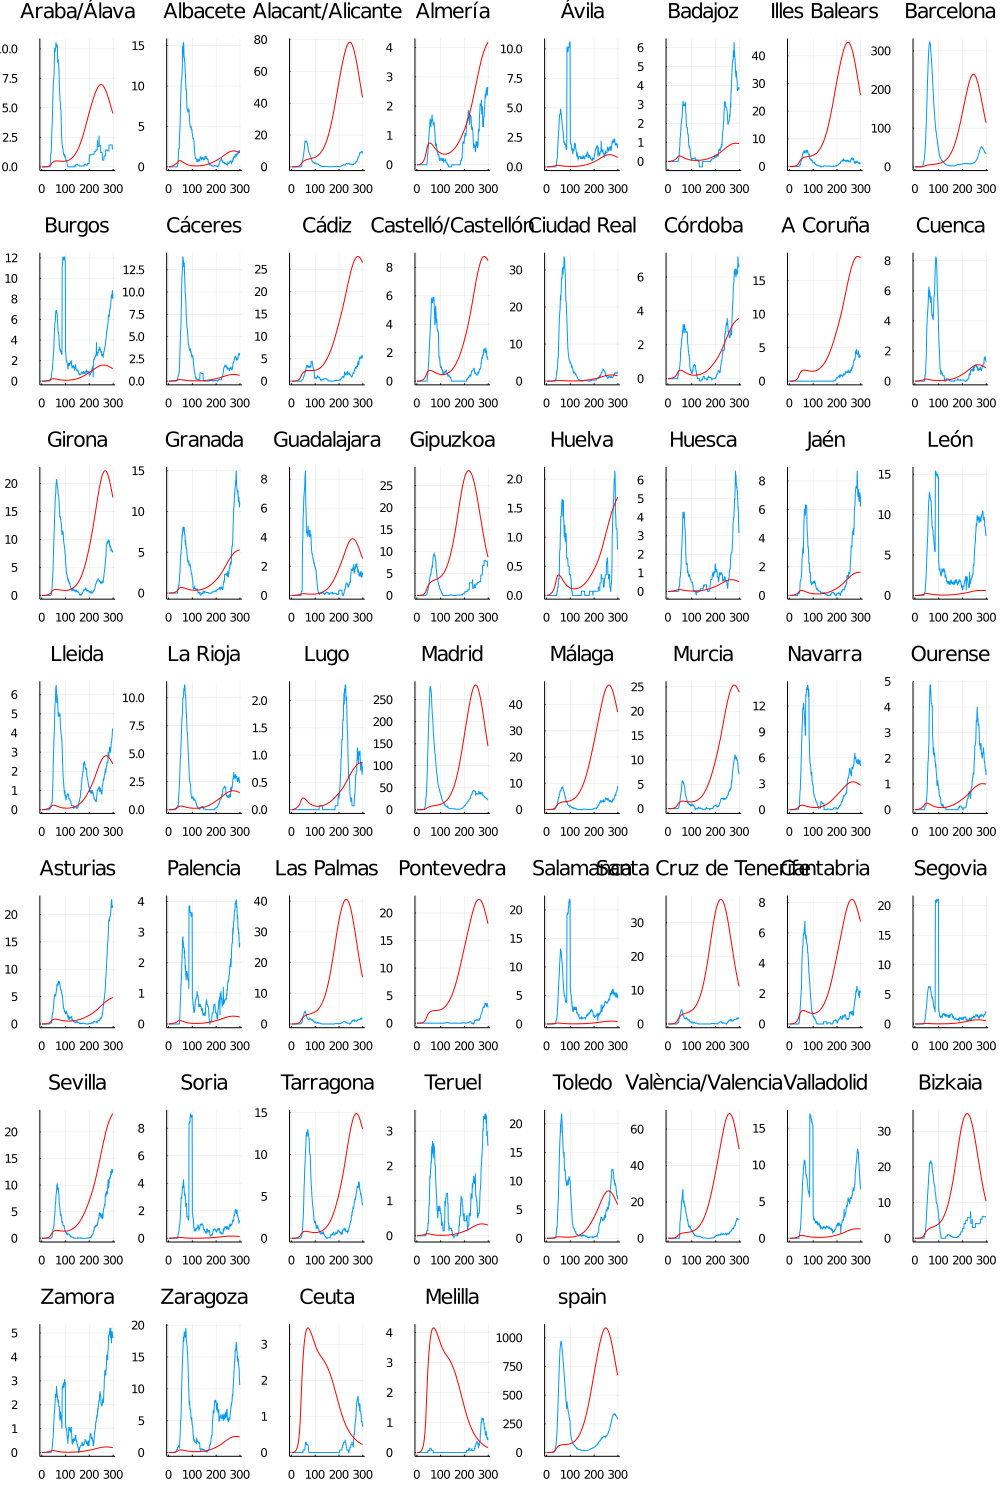

In [59]:
x0 = 10*ones(2+52)
x0[1] = 0.04
x0[2] = 0.5
x0[3] = 1

x0[3+1] = 50
x0[3+28] = 10

lower = zeros(3+52)
lower[1] = 0.03 # beta
lower[2] = 0.4 # scale_beta
lower[3] = 0 # multiplier


upper = 1000*ones(3+52)
upper[1] = 1
upper[2] = 0.6
upper[3] = 100

T = 300

deaths = run_model(x0, return_trajectories=true)
plot_multiple_provinces()

## optimization

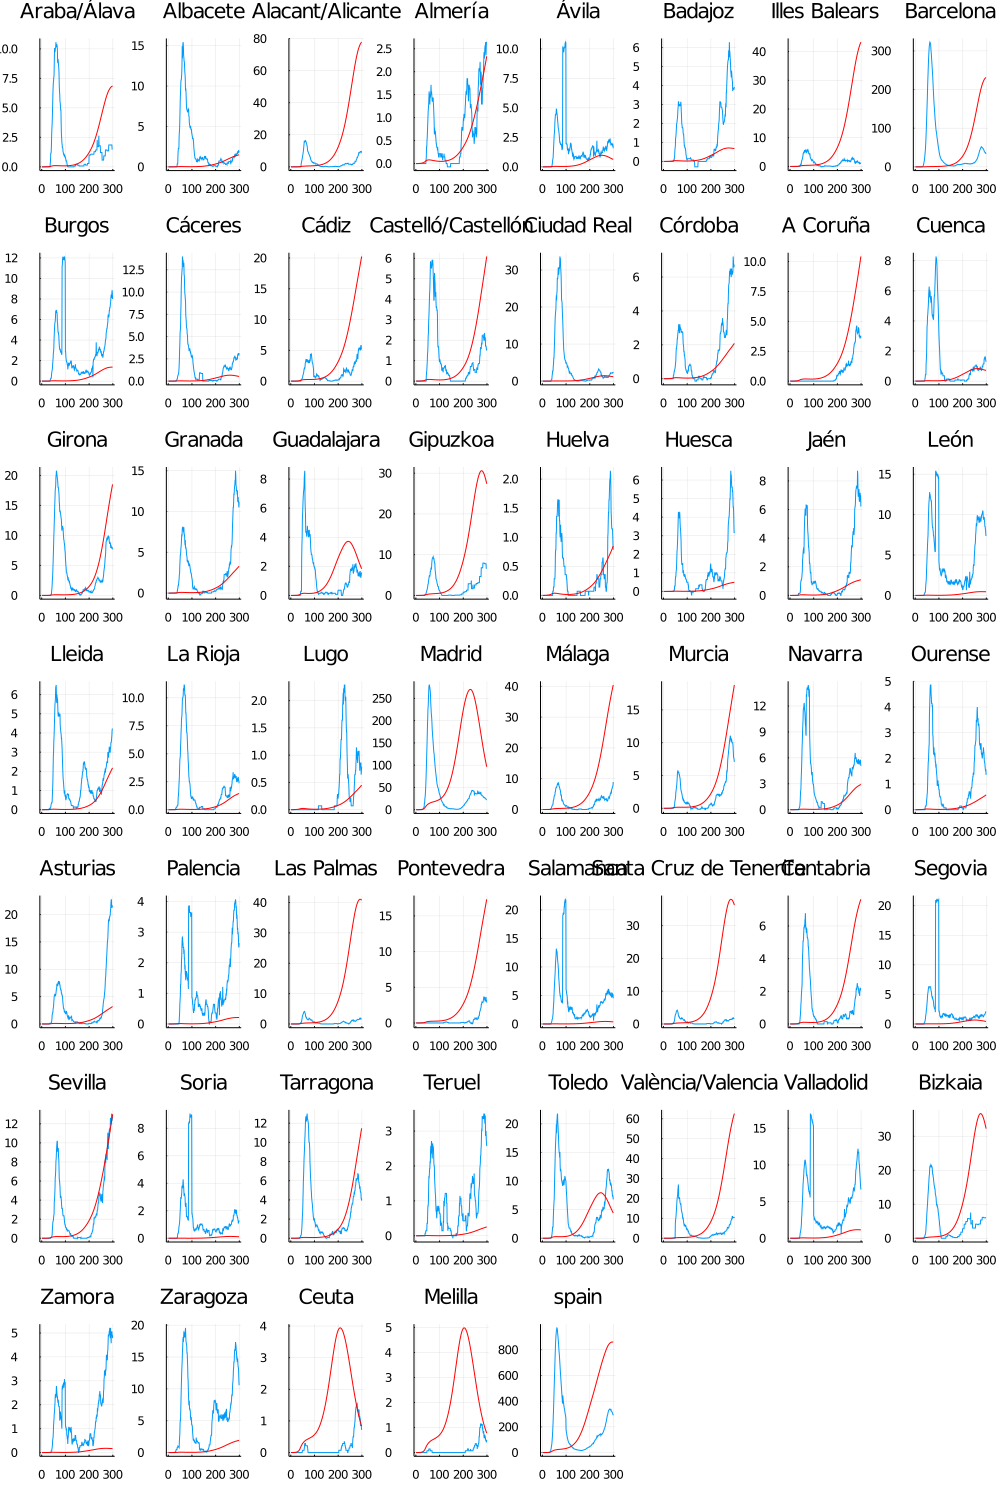

In [82]:
x0 = ones(3+52)
x0[1] = 0.04
x0[2] = 0.5
x0[3] = 1 # multiplier

x0[3+28] = 50

lower = zeros(3+52)
lower[1] = 0.04 # beta
lower[2] = 0.4 # scale_beta
lower[3] = 0.1 # seeds multiplier

upper = 100*ones(3+52)
upper[1] = 0.06
upper[2] = 0.6
upper[3] = 100

T = 300

deaths = run_model(x0, return_trajectories=true)
plot_multiple_provinces()


 * Status: failure (exceeded time limit of 1000.0)

 * Candidate solution
    Minimizer:  [0.04, 0.6, 0.1,  ...]
    Minimum:    1.5285732763868353e8
    Iterations: 562

 * Found with
    Algorithm: (15,30)-CMA-ES

 * Work counters
    Seconds run:   1001.025 (vs limit 1000.0)
    Iterations:    562
    f(x) calls:    17422
[0.04, 0.6, 0.1, 0.0, 0.0, 0.0, 0.0, 100.0, 100.0, 0.0, 100.0, 100.0, 0.0, 100.0, 0.0, 100.0, 100.0, 0.0, 0.0, 100.0, 100.0, 0.0, 100.0, 100.0, 100.0, 100.0, 0.0, 0.0, 0.0, 100.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 100.0, 100.0, 0.0, 100.0, 100.0, 0.0, 0.0, 0.0, 100.0, 100.0, 100.0, 0.0, 100.0, 0.0]

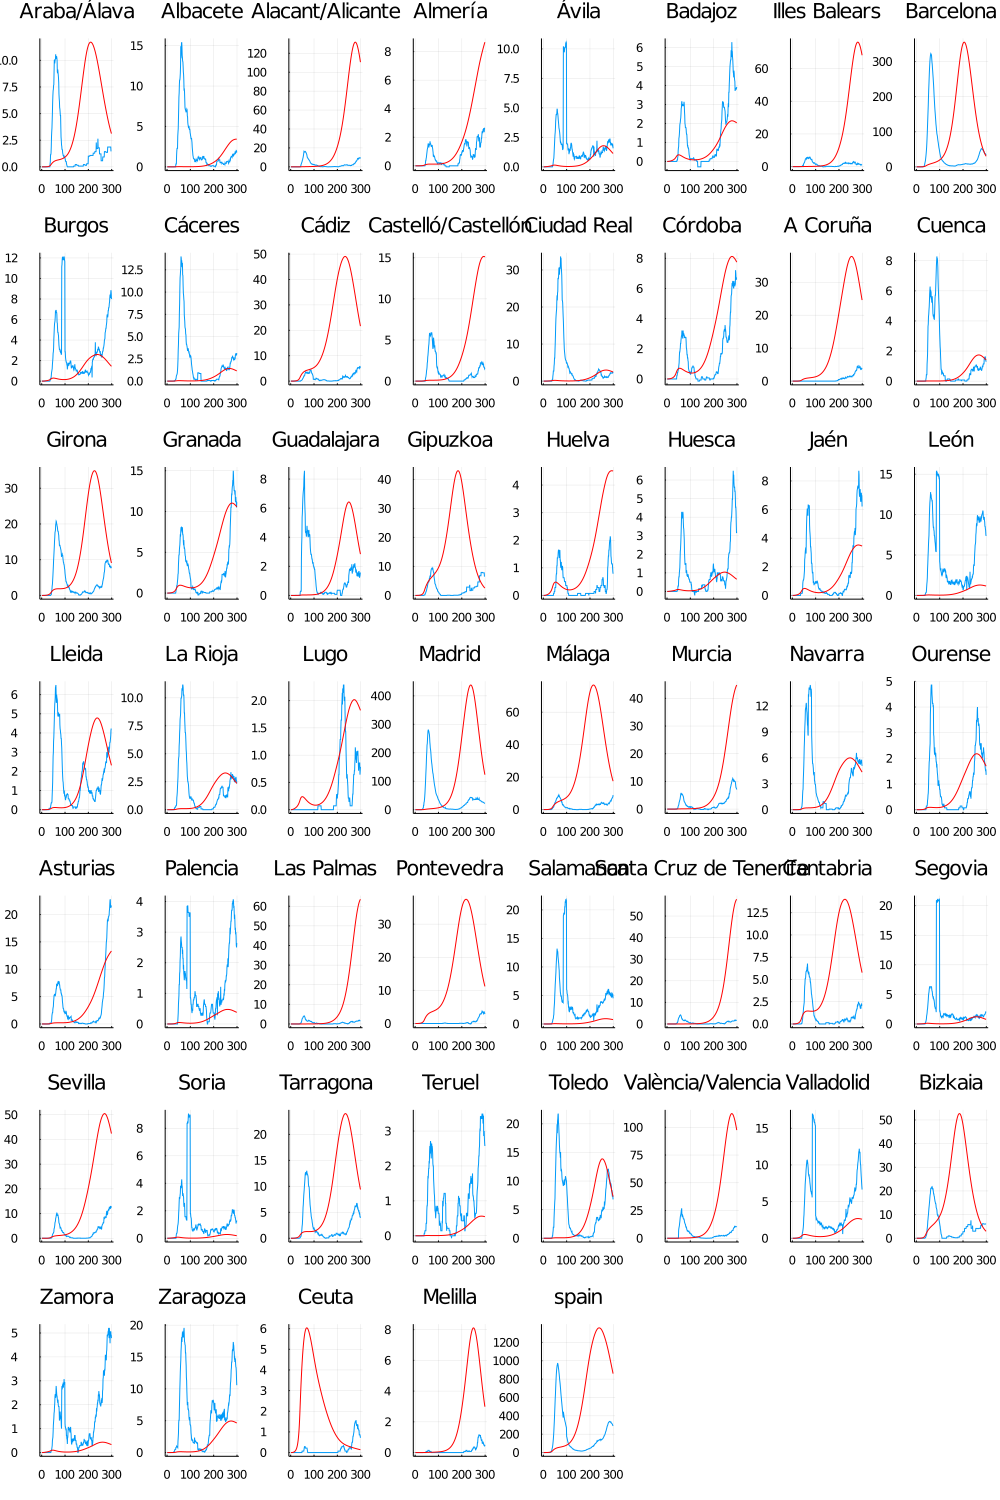

In [83]:
res = Evolutionary.optimize(run_model, lower, upper, x0, CMAES(), Evolutionary.Options(time_limit=1000.))
print(res)
params = Evolutionary.minimizer(res)
print(params)
deaths = run_model(params, return_trajectories=true)
plot_multiple_provinces()